## 1) lib import

In [15]:
import os
import torch
import numpy as np
import torch.nn as nn
import torchvision
from torchvision.datasets import cifar
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.transforms import v2
import torchvision
from torchsummary import summary
import warnings

warnings.filterwarnings('ignore')

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2"  # Set the GPU 2 to use

print(f'torch version : {torch.__version__}')
print(f'torchvision version : {torchvision.__version__}')
print(f'numpy version : {np.__version__}')

GLOBAL_BATCHSIZE = 32

torch version : 2.0.1+cu117
torchvision version : 0.15.2+cu117
numpy version : 1.23.5


## 2) Data load

In [3]:
# Define
img_dir = 'Downloads/CIFAR100'  

# Download
cifar100 = cifar.CIFAR100(img_dir, download=True, train=True)

Files already downloaded and verified


In [4]:
# getting image data and targets
dataset = cifar100.data
targets = cifar100.targets

# information on CIFAR100 dataset
print('CIFAR100 data shape:', dataset.shape) # array
print('CIFAR100 targets shape:', len(targets)) # list

CIFAR100 data shape: (50000, 32, 32, 3)
CIFAR100 targets shape: 50000


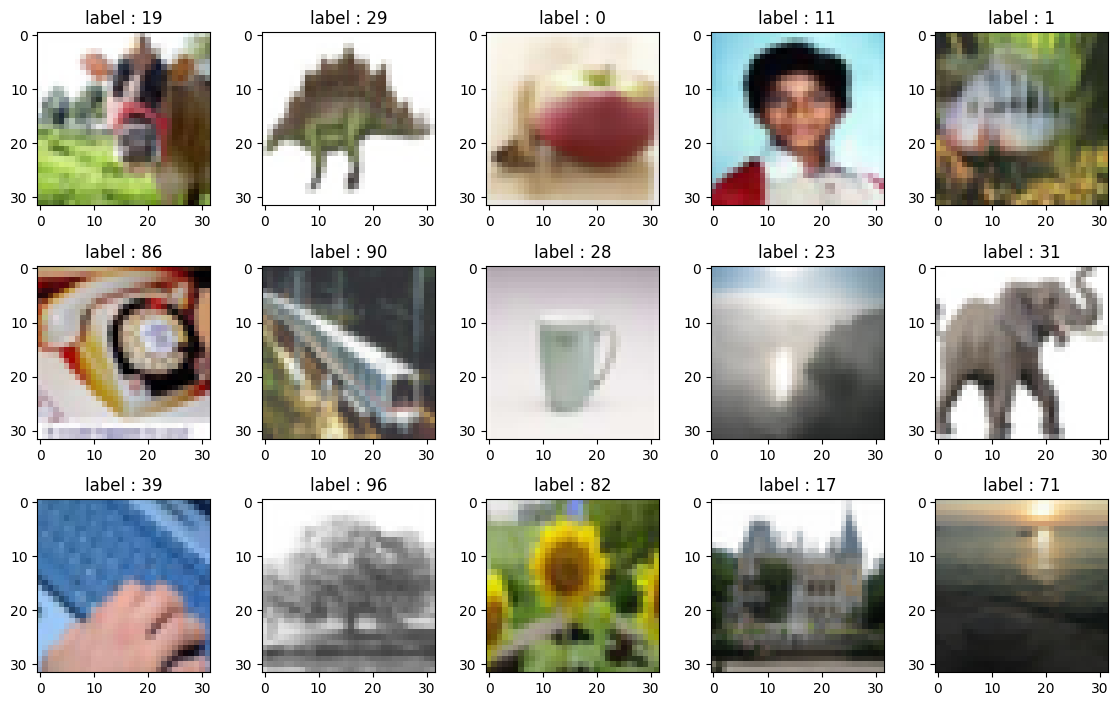

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

for i, (image, label) in enumerate(zip(dataset[:15], targets[:15])):
    plt.subplot(3, 5, i+1)
    plt.title(f'label : {label}')
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
    plt.imshow(image)

## 3) Data augmentation

In [6]:
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

# train dataloader
train_transform = transforms.Compose([transforms.Resize((224, 224), antialias=True),
                                      transforms.RandomHorizontalFlip(0.5), 
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      ])

trainset = torchvision.datasets.CIFAR100("Downloads/CIFAR100",
                                         train=True,
                                         download=True,
                                         transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, GLOBAL_BATCHSIZE, shuffle=True, num_workers=2, pin_memory=True)


# test dataloader
test_transform = transforms.Compose([transforms.Resize((224, 224), antialias=True),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                     ])

testset = torchvision.datasets.CIFAR100("Downloads/CIFAR100",
                                         train=False,
                                         download=True,
                                         transform=test_transform)

testloader = torch.utils.data.DataLoader(testset, GLOBAL_BATCHSIZE, shuffle=True, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


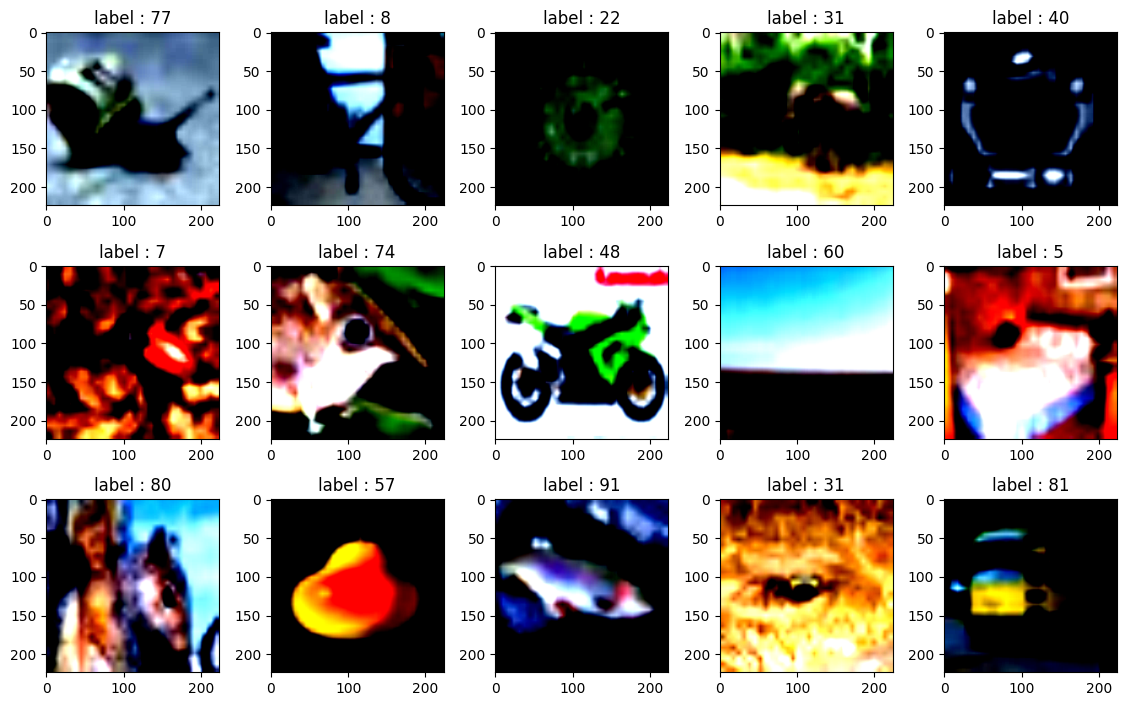

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

for images, labels in trainloader:
    for i, (image, label) in enumerate(zip(images[:15], labels[:15])):
        # define plt
        plt.subplot(3, 5, i+1)
        plt.title(f'label : {label}')
        plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

        # visualization
        plt.imshow(torch.clip(torch.permute(image, (1, 2, 0)), 0, 1))
        
    break

## 4) VGG

In [8]:
class advanced_VGG16(nn.Module):
    def __init__(self, num_classes, num_channels, num_layers, num_filters):
        super().__init__()
        self.classes = num_classes
        self.input_channels = num_channels
        
        conv_blcks = []
        for num_convs, filters in zip(num_layers, num_filters):
            conv_blcks.append(self.vgg_block(num_convs, self.input_channels, 64 * filters))
            self.input_channel = 64 * filters
            
        self.layers = nn.Sequential(
            *conv_blcks, 
            nn.Flatten(),
            nn.Linear((7 * 7 * 512), 4096),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, self.classes))
        
    def vgg_block(self, num_convs, in_channels, out_channels):
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(self.input_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            self.input_channels = out_channels

        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.layers(x)
        return out

## 5) Define VGG

In [9]:
# GPU 정의
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
FloatTensor = torch.cuda.FloatTensor

# Define VGG
model = advanced_VGG16(100, 3, [2, 2, 4, 4, 4], [1, 2, 4, 8, 8])
model.to(device)

advanced_VGG16(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [11]:
print(summary(model, (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

## 6) Training


> ### Training loop
1. 최상단 훈련 루프 (epoch)
2. network 훈련, 검증 모드 변경
3. epoch 별 loss, accuracy 초기화
4. 데이터로더를 통한 데이터 로드 정의
5. optimizer 초기화 (데이터 배치 당)
6. 예측 결과와 정답 값을 통한 손실 계산
7. 손실 값을 기반으로 오차역전파 계산 및 옵티마이저 업데이트
8. loss, accuracy 업데이트

In [29]:
def train(model, device, train_loader, optimizer, epoch):
    # 모드 변경
    model.train()
    
    # total loss, accuracy 초기화
    train_loss = 0
    train_accuracy = 0
    
    # training loop
    for batch_idx, (data,target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # loss, correct 누적
        _, preds = torch.max(output, 1)
        train_loss += criterion(output, target).item()
        train_accuracy += float((preds == target).sum())
        
    # epoch 당 손실, 정확도 계산
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)

    print("Train Loss", train_loss, epoch)
    print("Train Accuracy", train_accuracy, epoch)
    
    return train_loss, train_accuracy
            
def test(model, device, test_loader):
    # 모드 변경
    model.eval()
    
    # total loss, accuracy 초기화
    test_loss = 0
    test_accuracy = 0
    
    # evaluation loop
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(1)
            test_accuracy += float((pred == target).sum())
            
        test_loss /= len(test_loader.dataset)
        test_accuracy /= len(test_loader.dataset)
        return test_loss, test_accuracy

In [30]:
from tqdm import tqdm

# GPU 정의
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
FloatTensor = torch.cuda.FloatTensor

# Define VGG
model = advanced_VGG16(100, 3, [2, 2, 4, 4, 4], [1, 2, 4, 8, 8])
model.to(device)

# Define loss, optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# Define training Loop
result_train_loss, result_train_acc = [], []
result_test_loss, result_test_acc = [], []
for epoch in tqdm(range(10)):
    # training
    train_loss, train_accuracy = train(model, device, trainloader, optimizer, epoch)
    result_train_loss.append(train_loss)
    result_train_acc.append(train_accuracy)
    
    # test
    test_loss, test_accuracy = test(model, device, testloader)
    result_test_loss.append(test_loss)
    result_test_acc.append(test_accuracy)
    print(f"Testset Results = Epoch : {epoch}   Loss : {test_loss}   Accuracy : {test_accuracy}")

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss 0.13679765615463257 0
Train Accuracy 0.03842 0


 10%|█         | 1/10 [05:19<47:51, 319.04s/it]

Testset Results = Epoch : 0   Loss : 0.12454619688987732   Accuracy : 0.0882
Train Loss 0.12080031732559204 1
Train Accuracy 0.09814 1


 20%|██        | 2/10 [10:38<42:32, 319.00s/it]

Testset Results = Epoch : 1   Loss : 0.1102649418592453   Accuracy : 0.1483
Train Loss 0.11005855616092682 2
Train Accuracy 0.15072 2


 30%|███       | 3/10 [15:52<36:57, 316.78s/it]

Testset Results = Epoch : 2   Loss : 0.10088592774868012   Accuracy : 0.2123
Train Loss 0.09765736668109894 3
Train Accuracy 0.22608 3


 40%|████      | 4/10 [21:06<31:34, 315.76s/it]

Testset Results = Epoch : 3   Loss : 0.08756243934631347   Accuracy : 0.2937
Train Loss 0.08581060819387436 4
Train Accuracy 0.29662 4


 50%|█████     | 5/10 [26:25<26:25, 317.13s/it]

Testset Results = Epoch : 4   Loss : 0.0781404146194458   Accuracy : 0.353
Train Loss 0.07575307090759277 5
Train Accuracy 0.36264 5


 60%|██████    | 6/10 [31:40<21:04, 316.20s/it]

Testset Results = Epoch : 5   Loss : 0.06906402395963669   Accuracy : 0.414
Train Loss 0.06836627494096756 6
Train Accuracy 0.4126 6


 70%|███████   | 7/10 [36:59<15:51, 317.32s/it]

Testset Results = Epoch : 6   Loss : 0.06325921312570572   Accuracy : 0.4541
Train Loss 0.06262458167314529 7
Train Accuracy 0.4548 7


 80%|████████  | 8/10 [42:22<10:37, 318.99s/it]

Testset Results = Epoch : 7   Loss : 0.058168557465076445   Accuracy : 0.4893
Train Loss 0.05777980708003044 8
Train Accuracy 0.49232 8


 90%|█████████ | 9/10 [47:48<05:21, 321.28s/it]

Testset Results = Epoch : 8   Loss : 0.05731640323400498   Accuracy : 0.4981
Train Loss 0.05360972692966461 9
Train Accuracy 0.52174 9


100%|██████████| 10/10 [53:13<00:00, 319.37s/it]

Testset Results = Epoch : 9   Loss : 0.0543695062160492   Accuracy : 0.5237


## 7) Visualization

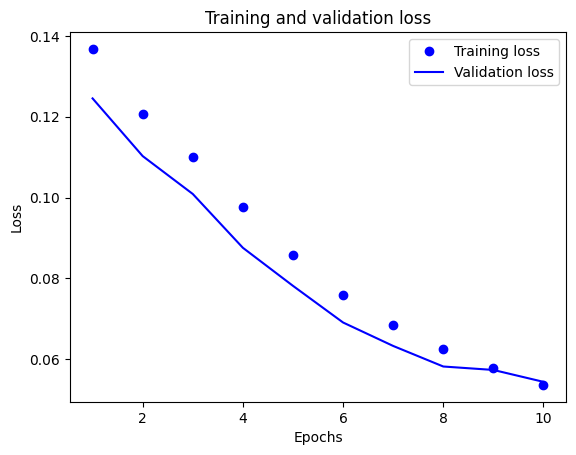

In [31]:
epochs = range(1, len(result_train_loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, result_train_loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, result_test_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

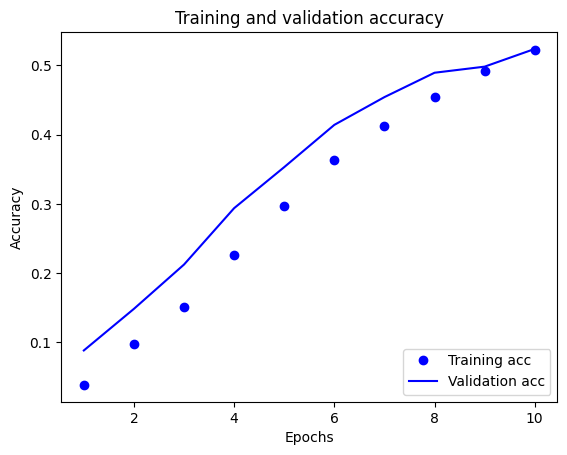

In [32]:
plt.plot(epochs, result_train_acc, 'bo', label='Training acc')
plt.plot(epochs, result_test_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()